In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsnooper
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.autograd import Variable

from dataFunc import tensor_load, tensor_save

import time

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
torch.cuda.current_device()

0

In [4]:
USE_CUDA = torch.cuda.is_available()

In [5]:
#加载训练数据
train_X = tensor_load('./dataset/train_X.npy')
train_y = tensor_load('./dataset/train_y.npy')

#加载验证数据
valid_X = tensor_load('./dataset/valid_X.npy')
valid_y = tensor_load('./dataset/valid_y.npy')

#加载测试数据
test_X = tensor_load('./dataset/test_X.npy')
test_y = tensor_load('./dataset/test_y.npy')

In [6]:
#torch中需要保证label大于0
train_y += 1
valid_y += 1
test_y += 1

In [7]:
valid_X, valid_y = Variable(valid_X).long(), Variable(valid_y).long()
test_X, test_y = Variable(test_X).long(), Variable(test_y).long()

In [8]:
if USE_CUDA:
    train_X, train_y = train_X.cuda(), train_y.cuda()
    valid_X, valid_y = valid_X.cuda(), valid_y.cuda()
    test_X, test_y = test_X.cuda(), test_y.cuda()
    

#构建训练数据集
train_dataset = TensorDataset(train_X, train_y)
valid_dataset = TensorDataset(valid_X, valid_y)

In [9]:
#加载词典
with open('./dataset/vocab_dict.json', 'r') as f:
    vocab_dict = json.load(f)


In [10]:
class LSTMModel(nn.Module):
    def __init__(self,vocab_size, embedding_size, output_size, pad_idx, hidden_size, num_layers, bidirectional, dropout):
        super(LSTMModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size, padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers = num_layers, bidirectional = bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.f1 = nn.Sequential(nn.Linear(hidden_size * 2, output_size),
                                nn.Softmax())
        
    def forward(self, text):
        x = self.embed(text) 
        x = self.dropout(x.permute(1,0,2)) #原词向量形状 (batch_size, seq_len, embedding_size)
        x, (hidden, cell) = self.lstm(x)

        hidden = torch.cat([hidden[-1], hidden[-2]], dim = 1)
        x = self.dropout(hidden.squeeze())
        return self.f1(x)

In [11]:
class GRUModel(nn.Module):
    def __init__(self,vocab_size, embedding_size, output_size, pad_idx, hidden_size, num_layers, bidirectional, dropout):
        super(GRUModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size, padding_idx = pad_idx)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers = num_layers, bidirectional = bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.f1 = nn.Sequential(nn.Linear(hidden_size * 2, hidden_size),
                                nn.Dropout(dropout),
                                nn.ReLU())
        self.f2 = nn.Sequential(nn.Linear(hidden_size, output_size),
                               nn.Softmax())
        
    def forward(self, text):
        x = self.embed(text)  #原词向量形状 (batch_size, seq_len, embedding_size)   .permute(1,0,2)
        x, _ = self.gru(x)
        x = self.dropout(x)
        x = self.f1(x[:, -1, :])
        return self.f2(x)

In [12]:
class CNNModel(nn.Module):
    def __init__(self,vocab_size, embedding_size, output_size, pad_idx, num_filters, filter_sizes, dropout):
        super(CNNModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                        nn.Conv2d(in_channels = 1, out_channels = num_filters, kernel_size = (fs, embedding_size))
                        for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.f1 = nn.Linear(num_filters * len(filter_sizes), output_size)
        
    def forward(self, text):
        #text.shape(batch_size, seq_len)
        x = self.embed(text) # (batch_size, seq_len, embedding_size)
        x = x.unsqueeze(1) #(batch_size, 1, seq_len, embedding_size)
        convd = [F.relu(conv(x)).squeeze(3) for conv in self.convs] #(batch_size, num_filters, seq_len - filter_size + 1, 1)
#         x = F.max_pool1d(x, x.shape[2])# (batch_size, num_filters, 1)
#         x = x.squeeze(2)
        x = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convd] # (batch_size, 3 * num_filters)
        x = torch.cat(x, dim = 1)
        x = self.dropout(x)
        return self.f1(x)

In [58]:
class LSTM_CNNModel(nn.Module):
    def __init__(self,vocab_size, embedding_size, output_size,num_layers, hidden_size, bidirectional, 
                 pad_idx, num_filters, filter_sizes, dropout):
        super(LSTM_CNNModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size, padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers = num_layers, bidirectional = bidirectional)
        self.dropout = nn.Dropout(dropout)
        
        if bidirectional:
        
            self.convs = nn.ModuleList([
                            nn.Conv2d(in_channels = 1, out_channels = num_filters, kernel_size = (fs, hidden_size * 2))
                            for fs in filter_sizes
            ])
        else:
            self.convs = nn.ModuleList([
                        nn.Conv2d(in_channels = 1, out_channels = num_filters, kernel_size = (fs, hidden_size))
                        for fs in filter_sizes
            ])
        self.dropout = nn.Dropout(dropout)
        self.f1 = nn.Linear(num_filters * len(filter_sizes), output_size)
        
    def forward(self, text):
        #text.shape(batch_size, seq_len)
        x = self.embed(text) # (batch_size, seq_len, embedding_size)
        
        x = self.dropout(x.permute(1,0,2)) #原词向量形状 (batch_size, seq_len, embedding_size)
        x, (hidden, cell) = self.lstm(x)
        #hidden = torch.cat([hidden[-1], hidden[-2]], dim = 1)
        x = x.unsqueeze(1) #(seq_len, 1, batch_size, hidden_size * 双向（2）)
        x = x.permute(2, 1, 0, 3)
        convd = [F.relu(conv(x)).squeeze(3) for conv in self.convs] #(batch_size, num_filters, seq_len - filter_size + 1, 1)
        
        x = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convd] # (batch_size, 3 * num_filters)
        x = torch.cat(x, dim = 1)
        x = self.dropout(x)
        return self.f1(x)

In [93]:
class CNN_LSTMModel(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size, num_layers, hidden_size, bidirectional, pad_idx,
                 num_filters, filter_sizes, dropout):
        super(CNN_LSTMModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                        nn.Conv2d(in_channels = 1, out_channels = num_filters * 2, kernel_size = (fs, embedding_size))
                        for fs in filter_sizes
        ])
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers = num_layers, bidirectional = bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.f1 = nn.Sequential(nn.Linear(hidden_size * 2, output_size),
                                nn.Softmax())
        

    def forward(self,text):
        ## CNN
        #text.shape(batch_size, seq_len)
        x = self.embed(text)  # (batch_size, seq_len, embedding_size)
        x = x.unsqueeze(1)  # (batch_size, 1, seq_len, embedding_size)
        convd = [F.relu(conv(x)).squeeze(3) for conv in
                 self.convs]  # (batch_size, num_filters, seq_len - filter_size + 1, 1)
        #         x = F.max_pool1d(x, x.shape[2])# (batch_size, num_filters, 1)
        #         x = x.squeeze(2)
        x = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convd]  # (batch_size, 3 * num_filters)
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        ## LSTM
        x = x.unsqueeze(0)
        x, (hidden, cell) = self.lstm(x)
        hidden = torch.cat([hidden[-1], hidden[-2]], dim = 1)
        x = self.dropout(hidden.squeeze())

        return self.f1(x)

In [14]:
#正确率计算

from sklearn.metrics import f1_score, precision_score, recall_score

def accuracy_computing(preds, y):
    rounded_preds = preds.argmax(dim = 1)
    #print(rounded_preds.shape)
    #print(y.shape)
    correct = (rounded_preds == y).float()
    #print(rounded_preds)
    #print(y)
    acc = correct.sum() / len(correct)
    MAP = f1_score(y.cpu().detach().numpy(), rounded_preds.cpu().detach().numpy(), average = 'macro', labels=[0, 1, 2])
    return acc, MAP
    

In [78]:
#超参定义
VOCAB_SIZE = len(vocab_dict)
EMBEDDING_SIZE = 128
PAD_IDX = vocab_dict['<pad>'] # 就是<pad>的index
UNK_IDX = vocab_dict['<unk>'] #<unk>的index

OUTPUT_SIZE = 3 #输出结果为1个数

In [79]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
num_layers = 2
bidirectional = True
hidden_size = 128
dropout = 0.5
epoches = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
train_loader = DataLoader(train_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True,
                        num_workers = 0)

valid_loader = DataLoader(valid_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = True,
                         num_workers = 0)

In [38]:
METHOD = 'lstm-cnn'

In [94]:
#模型声明
if METHOD == 'lstm':
    model = LSTMModel(vocab_size = VOCAB_SIZE, 
                     embedding_size = EMBEDDING_SIZE,
                     output_size = OUTPUT_SIZE,
                     pad_idx = PAD_IDX,
                     num_layers = num_layers,
                     bidirectional = bidirectional,
                     hidden_size = hidden_size,
                     dropout = dropout)
elif METHOD == 'gru':
    model = GRUModel(vocab_size = VOCAB_SIZE, 
                     embedding_size = EMBEDDING_SIZE,
                     output_size = OUTPUT_SIZE,
                     pad_idx = PAD_IDX,
                     num_layers = num_layers,
                     bidirectional = bidirectional,
                     hidden_size = hidden_size,
                     dropout = dropout)
elif METHOD == 'cnn':
    model = CNNModel(vocab_size = VOCAB_SIZE, 
                     embedding_size = EMBEDDING_SIZE,
                     output_size = OUTPUT_SIZE,
                     pad_idx = PAD_IDX,
                     num_filters = 100,
                     filter_sizes = [3, 4, 5], 
                     dropout = dropout
                    )
    
elif METHOD == 'lstm-cnn':
    model = LSTM_CNNModel(vocab_size = VOCAB_SIZE, 
                     embedding_size = EMBEDDING_SIZE,
                     output_size = OUTPUT_SIZE,
                     pad_idx = PAD_IDX,
                     num_layers = num_layers,
                     bidirectional = bidirectional,
                     hidden_size = hidden_size,
                     dropout = dropout,
                     num_filters = 64,
                     filter_sizes = [3]
                    )

elif METHOD == 'cnn-lstm':
    model = CNN_LSTMModel(vocab_size = VOCAB_SIZE, 
                     embedding_size = EMBEDDING_SIZE,
                     output_size = OUTPUT_SIZE,
                     pad_idx = PAD_IDX,
                     num_layers = num_layers,
                     bidirectional = bidirectional,
                     hidden_size = hidden_size,
                     dropout = dropout,
                     num_filters = 32,
                     filter_sizes = [3]
                    )

model.embed.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)
model.embed.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)

In [82]:
#设置损失函数与优化器
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

model = model.to(device)
Loss = Loss.to(device)

In [21]:
device

device(type='cuda')

In [22]:
#单epoch训练函数
#@torchsnooper.snoop()
def train(model, Loss, optimizer, train_loader):
    epoch_loss, epoch_acc ,epoch_MAP = 0., 0., 0.
    total_len = 0
    model.train()
    for step, data in enumerate(train_loader):
        start = time.clock()
        batch_x, batch_y = data
        #print(model.device)
        # 将这些数据转换成Variable类型
        batch_x, batch_y = Variable(batch_x).long(), Variable(batch_y).long()
        output = model(batch_x)
        
        acc, MAP = accuracy_computing(output, batch_y.squeeze())
        loss = Loss(output, batch_y.squeeze())
        #SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * len(batch_y)
        epoch_acc += acc.item() * len(batch_y)
        epoch_MAP += MAP.item() * len(batch_y)
        total_len += len(batch_y)
        
        
        total_loss = epoch_loss / total_len
        total_acc =  epoch_acc / total_len
        total_MAP = epoch_MAP / total_len
        end = time.clock()
        #print('Step:', step, 'Train Loss: %0.6f'% loss.data, 'Train Accuracy: %0.4f'% acc, 'Train MAP:',MAP ,'Time: %0.6f'% (end-start))
    return total_loss, total_acc, total_MAP
        

In [23]:
#评估模型
def evaluate(model, Loss, optimizer, valid_loader):
    epoch_loss, epoch_acc ,epoch_MAP = 0., 0., 0.
    total_len = 0
    model.eval()
    for step, data in enumerate(valid_loader):
        batch_x, batch_y = data
        # 将这些数据转换成Variable类型
        batch_x, batch_y = Variable(batch_x).long(), Variable(batch_y).long()
        output = model(batch_x)
        
        acc, MAP = accuracy_computing(output, batch_y.squeeze())
        loss = Loss(output, batch_y.squeeze())
        
        epoch_loss += loss.item() * len(batch_y)
        epoch_acc += acc.item() * len(batch_y)
        epoch_MAP += MAP.item() * len(batch_y)
        total_len += len(batch_y)
        
        total_loss = epoch_loss / total_len
        total_acc =  epoch_acc / total_len
        total_MAP = epoch_MAP / total_len
    model.train()
    return total_loss, total_acc, total_MAP
        

In [83]:
#训练开始
best_valid_acc = 0.
best_epoch = 0
best_valid_loss = 0.

train_loss_list = []
valid_loss_list = []

for epoch in range(epoches):
    print("进行第{}个epoch".format(epoch))
    
    train_loss, train_acc, train_MAP = train(model, Loss, optimizer, train_loader)
    valid_loss, valid_acc, valid_MAP = evaluate(model, Loss, optimizer, valid_loader)
    
    if valid_acc > best_valid_acc:
        best_epoch = epoch
        best_valid_acc = valid_acc
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-cnn-model-epoch30-embed128-lr0001-bz128-dp05-filter64-hz128.pth')
        
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print('-'*20)
    print('Epoch:', epoch, 'Train Loss: %0.6f'% train_loss, 'Train MAP:',train_MAP , 'Train Accuracy: %0.4f'% train_acc)
    print('Epoch:', epoch, 'Valid Loss: %0.6f'% valid_loss, 'Valid MAP:',valid_MAP , 'Valid Accuracy: %0.4f'% valid_acc)
    print('-'*20)
print("Train finished!")
print('Best Epoch:', best_epoch, 'Best Valid Loss:%0.6f'% best_valid_loss, 'Best Valid Accuracy: %0.4f'% best_valid_acc)

进行第0个epoch


/home/dingmuhe/conda/envs/begin/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/dingmuhe/conda/envs/begin/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


--------------------
Epoch: 0 Train Loss: 0.875899 Train MAP: 0.40507039459980215 Train Accuracy: 0.6220
Epoch: 0 Valid Loss: 0.820566 Valid MAP: 0.48379780347217705 Valid Accuracy: 0.6432
--------------------
进行第1个epoch
--------------------
Epoch: 1 Train Loss: 0.833032 Train MAP: 0.45583077130979127 Train Accuracy: 0.6405
Epoch: 1 Valid Loss: 0.803826 Valid MAP: 0.46309584989196384 Valid Accuracy: 0.6517
--------------------
进行第2个epoch
--------------------
Epoch: 2 Train Loss: 0.814974 Train MAP: 0.4684669702240651 Train Accuracy: 0.6486
Epoch: 2 Valid Loss: 0.795683 Valid MAP: 0.47776044939475576 Valid Accuracy: 0.6582
--------------------
进行第3个epoch
--------------------
Epoch: 3 Train Loss: 0.799001 Train MAP: 0.4807225176395516 Train Accuracy: 0.6531
Epoch: 3 Valid Loss: 0.785378 Valid MAP: 0.50230537986196 Valid Accuracy: 0.6624
--------------------
进行第4个epoch
--------------------
Epoch: 4 Train Loss: 0.785658 Train MAP: 0.4961435186693958 Train Accuracy: 0.6572
Epoch: 4 Valid Lo

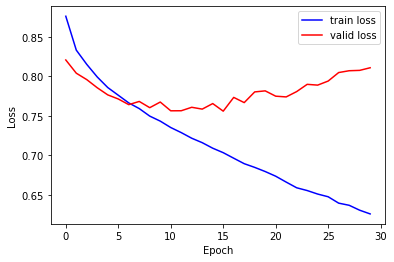

In [84]:
import matplotlib.pyplot as plt

plt.plot(list(range(epoches)), train_loss_list, c = 'b', label = 'train loss')
plt.plot(list(range(epoches)), valid_loss_list, c = 'r', label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [212]:
import spacy

nlp = spacy.load('zh')

def predict_sentence(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [vocab_dict[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    pred = model(tensor).argmax(dim = 1)
    return pred.item()
    

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [86]:
torch.save(model.state_dict(), 'lstm-cnn-model-epoch30-embed128-lr0001-bz128-dp05-filter64-hz128-06630.pth')

In [90]:
# model = LSTMModel(vocab_size = VOCAB_SIZE, 
#                  embedding_size = EMBEDDING_SIZE,
#                  output_size = OUTPUT_SIZE,
#                  pad_idx = PAD_IDX,
#                  num_layers = num_layers,
#                  bidirectional = bidirectional,
#                  hidden_size = hidden_size,
#                  dropout = dropout)


#model.load_state_dict(torch.load('lstm-cnn-model-epoch60-embed128-lr001-bz128-dp05-filter100-06550.pth'))
model.load_state_dict(torch.load("lstm-cnn-model-epoch30-embed128-lr0001-bz128-dp05-filter64-hz128.pth"))
model.eval()
#predict_model.to(device)

LSTM_CNNModel(
  (embed): Embedding(48074, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 256), stride=(1, 1))
  )
  (f1): Linear(in_features=64, out_features=3, bias=True)
)

In [92]:
test_acc, test_MAP = accuracy_computing(model(test_X), test_y.squeeze())
print(test_acc)
print(test_MAP)

tensor(0.6750, device='cuda:0')
0.566357051445898


In [54]:
#model参数
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

6967731

In [55]:
next(model.parameters()).numel()

6153472